# TODO fase 1
 - use hooks to verify that the weights has a sufficeint variance
 - calculate candlestick using pca
 - calculate predictions for a stock fx apple
 - statistics for the predictions: distribution of errors, percentage prediction with the right direction:  close>open, open<close
 - visualize ohlc as bands and on stock curve

 - tjek quantile objective function
 - objectiv function that weigh open and closing prices higher

 - add day of week to training data
                                                                                                                 
                                                                                                                 
# TODO fase 2
 - language modelling
                                                                                                                                                                                                                                    
# DONE
 - augmentation of training data by mixing stock prices
 - split in train, test so that test data are taken from time periodens after the training data and possibly from stocks that have not been used for training 
                
                                                                                                                                   

# DONE 
 - speed up training: improve the pandas part by 30 to 60 times


In [ ]:
#default_exp finance.train

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from lib.data.lists import *
from lib.finance.data import *
from pathlib import Path

import pandas as pd
import numpy as np

#import matplotlib.pyplot as plt

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [ ]:
# Version of the SimFin Python API.
sf.__version__

'0.8.1'

# Network architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from lib.model.model import *
from functools import reduce

#import torch.multiprocessing as mp
import multiprocess as mp

#torch.nn.Tanh(), torch.nn.ReLU(inplace=False), #     torch.nn.Tanh(), #nn.LeakyReLU(inplace=True), #

class Block(nn.Sequential):
    def __init__(self, res_in_dim, res_n_width, activ_func=torch.nn.Tanh(), dropout_ratio=0.0):
        super().__init__(
                            torch.nn.BatchNorm1d(1),
                            nn.Dropout(p=dropout_ratio, inplace=False),
                            activ_func,
                            nn.Linear(res_in_dim, res_in_dim*res_n_width),
                          
                            torch.nn.BatchNorm1d(1),
                            nn.Dropout(p=dropout_ratio, inplace=False),
                            activ_func,
                            #nn.AvgPool1d(kernel_size=nb_reswidth_multiple),
                            nn.Linear(res_in_dim*res_n_width, res_in_dim),
                            )
        
class DenseResBlock(nn.Module):
    def __init__(self, res_in_dim, res_n_width, activ_func=torch.nn.Tanh(), dropout_ratio=0.0):
        super().__init__()
        self.block_1 = Block(res_in_dim, res_n_width, activ_func, dropout_ratio)
    def forward(self,x):
        #print(f"1 ResBlock forward x.shape:{x.shape}")
        x_out = self.block_1(x)
        #print(f"2 ResBlock forward x_out.shape:{x_out.shape}") 
        x3 = x+x_out
        #print(f"2 ResBlock forward x3.shape:{x3.shape}") 
        return x3

class DenseResNetModel(nn.Module):
    def __init__(self, L0_in_dim, L0_out_dim, L0_n_out_dim, nb_res, 
                       res_in_dim, res_n_width, 
                       fadeout_n_dim, 
                       activ_func=torch.nn.Tanh(), dropout_ratio=0.0 ):
        super().__init__()
        self.stem = nn.Sequential(
                        nn.Linear(L0_in_dim,L0_out_dim*L0_n_out_dim),
                        torch.nn.BatchNorm1d(1),
                        nn.Dropout(p=dropout_ratio, inplace=False),
                        activ_func, 
                        nn.AvgPool1d(kernel_size=L0_n_out_dim),
            
                        nn.Linear(L0_out_dim,res_in_dim)
    
                        #torch.nn.BatchNorm1d(1),
                        #nn.Dropout(p=dropout_ratio, inplace=False),
                        #activ_func, 
                        #nn.Linear(embedding_width,res_in_dim)
            )
                        
        blocks = [DenseResBlock(res_in_dim, res_n_width, activ_func, dropout_ratio) 
                  for i in np.arange(nb_res)]
        self.resblocks = nn.Sequential(*blocks)

        
        self.fadeout = nn.Sequential(
            nn.Linear(res_in_dim,res_in_dim*fadeout_n_dim),
            torch.nn.BatchNorm1d(1),
            activ_func,
    
            nn.Linear(res_in_dim*fadeout_n_dim,1),
            nn.Flatten()
            )

    # fast and consumes less memeory comparede to the reduce and comprehension version
    def forward(self,x):
        #print(f"1 DenseResNetModel forward x.shape:{x.shape}")
        x_stem = self.stem.forward(x)
        #print(f"2 DenseResNetModel forward x_stem.shape:{x_stem.shape}")
        x_resblocks = self.resblocks(x_stem)
        #print(f"3 DenseResNetModel forward x_stem.shape:{x_stem.shape}")
        x_fadeout   = self.fadeout(x_resblocks)
        #print(f"4 DenseResNetModel forward x_fadeout.shape:{x_fadeout.shape}")
        return x_fadeout      
    


# Load data


In [ ]:
%%time
df_prices = loadShareprices()
df_prices, stocks, validStocks, inValidStocks = procesSharePrices(df_prices)

dataPath:/Users/kasparlund/simfin_data exists:True
Dataset "us-shareprices-daily" on disk (1 days old).
- Loading from disk ... Done!
number of stocks:         2618
number of valid stocks:   1626
number of invalid stocks: 992
smallest pricelines pr stock: Ticker
NLN      1
LMND     2
DNB      3
ACI      6
OPEN    12
dtype: int64
longest pricelines pr stock:  Ticker
HTLD     3400
HTH      3400
IBM      3400
KEY      3400
FCAUS    3425
dtype: int64
CPU times: user 1min 18s, sys: 4.31 s, total: 1min 23s
Wall time: 1min 23s


In [ ]:
#statistics on the mature stocks
stats = df_prices.loc[validStocks,[PREV_CLOSE,OPEN,HIGH,LOW,CLOSE]].describe(percentiles=[0.001, 0.01, 0.25, 0.75, 0.99, 0.999])        
stats

,previous_close,Open,High,Low,Close
count,4.381883e+06,4.381883e+06,4.381883e+06,4.381883e+06,4.381883e+06
mean,3.467543e+00,1.129824e-04,1.484703e-02,-1.531470e-02,1.773332e-04
std,9.839195e-01,1.401605e-02,2.168032e-02,2.302438e-02,2.629342e-02
min,-3.912023e+00,-4.829644e-01,-4.327939e-01,-4.995624e-01,-4.867261e-01
0.1%,9.531018e-02,-1.129393e-01,-7.089721e-02,-2.171754e-01,-1.732420e-01
1%,1.071584e+00,-4.015526e-02,-1.898795e-02,-1.016918e-01,-7.626433e-02
25%,2.888704e+00,-3.805386e-03,3.733247e-03,-2.104773e-02,-9.978700e-03
50%,3.489513e+00,0.000000e+00,1.027246e-02,-1.016560e-02,2.618829e-04
75%,4.049173e+00,4.390786e-03,2.038105e-02,-3.316753e-03,1.072309e-02
99%,5.858824e+00,3.846628e-02,9.619240e-02,1.830969e-02,7.492761e-02


In [ ]:
%%time
df_valid =df_prices.loc[validStocks]
print( f"percentage =>0: {df_valid[CLOSE].ge(0).sum()/len(df_valid)*100}")
print( f"percentage ==0: {df_valid[CLOSE].eq(0).sum()/len(df_valid)*100}")
print( f"percentage  <0: {df_valid[CLOSE].lt(0).sum()/len(df_valid)*100}")

print( f"mean=0 percentage =>0: {(df_valid[CLOSE]-stats.loc['mean',CLOSE]).ge(0).sum()/len(df_valid)*100}")
print( f"mean=0 percentage ==0: {(df_valid[CLOSE]-stats.loc['mean',CLOSE]).eq(0).sum()/len(df_valid)*100}")
print( f"mean=0 percentage  <0: {(df_valid[CLOSE]-stats.loc['mean',CLOSE]).lt(0).sum()/len(df_valid)*100}")
del df_valid

percentage =>0: 52.54537832251569
percentage ==0: 2.2496264733677283
percentage  <0: 47.45462167748432
mean=0 percentage =>0: 50.174274392994974
mean=0 percentage ==0: 0.0
mean=0 percentage  <0: 49.825725607005026
CPU times: user 367 ms, sys: 122 ms, total: 488 ms
Wall time: 487 ms


In [ ]:
%%time 
from lib.learner.learner import*
from lib.learner.optimizers import*
from lib.model.model import*
from lib.model.modelmanager import*
import torch.nn as nn

#mean is so close to zero so we only devide by std
stats = df_prices.loc[validStocks].describe(percentiles=[0.001, 0.01, 0.25, 0.75, 0.99, 0.999])
df_prices, normalized_columns = normalizeData(df_prices,stats)

#truncate extrems
stats = df_prices.loc[validStocks,normalized_columns].describe(percentiles=[0.001, 0.01, 0.25, 0.75, 0.99, 0.999])
df_prices = truncateExtremes(df_prices,normalized_columns, stats, "1%", "99%")

CPU times: user 3.45 s, sys: 993 ms, total: 4.44 s
Wall time: 4.46 s


In [ ]:
from dataclasses import dataclass, field
"""
@dataclass
class ValueRange:
    default:int=0
    range_:range = range(0, 2, 1)
    def __call__( self, source ): return source
"""        
@dataclass
class TrainingParams:
    seq_length:int = 90
    n_predict_columns:int = 1
    training_columns: list = field(default_factory=list)
        
    L0_in_dim:int=0
    L0_out_dim:int = 4*64  
    L0_n_out_dim:int=9
        
    n_res:int = 1
    res_in_dim:int = 64
    res_n_width:int=1 
    
    fadeout_n_dim:int = 2
    
    dropout_ratio:float=0.5,
    mixing:float=0.0
tp = TrainingParams()
tp.training_columns = [CLOSE_NORM,OPEN_NORM]
tp.L0_in_dim = tp.seq_length*len(tp.training_columns)
#tp.embedding_width=tp.len_of_samples
print(f"{tp}")


TrainingParams(seq_length=90, n_predict_columns=1, training_columns=['Close_normalized', 'Open_normalized'], L0_in_dim=180, L0_out_dim=256, L0_n_out_dim=9, n_res=1, res_in_dim=64, res_n_width=1, fadeout_n_dim=2, dropout_ratio=(0.5,), mixing=0.0)


In [ ]:
%%time

train_test_default = "default"
data = Data(df_prices)
data.changeTraining(tp.seq_length,tp.training_columns,tp.n_predict_columns, train_test_default)

ohlc_ds = OHLCDataset(data, validStocks, train_test_default)


#train_ds, test_ds = ohlc_ds.split2train_test("stock",0.25)
train_ds, test_ds = ohlc_ds.split2train_test("time",0.25)
train_ds.changeAugmentation(tp.mixing)

databunch = DataBunch(train_ds.dataloader(batch_size=2048, shuffle=True,  drop_last=True), \
                      test_ds.dataloader( batch_size=4096, shuffle=False, drop_last=False), \
                      c_in=len(ohlc_ds.data.columns), c_out=len(ohlc_ds.data.columns))

print(f"number of ValidStocks, train, test inValid: {len(ohlc_ds.stocks), len(train_ds.stocks), len(test_ds.stocks), len(inValidStocks)}")
print(f"number of samples: len(ohlc_ds),len(train_ds),len(test_ds): {len(ohlc_ds),len(train_ds),len(test_ds)}")

#print("the following lengths must be the same")
#%time stock_days = [len(ohlc_ds.stock_grps.get_group(stock)) for stock in ohlc_ds.stocks]
#print(len(ohlc_ds), sum(stock_days)-len(stock_days)*(seq_length+1))

number of ValidStocks, train, test inValid: (1626, 1626, 1626, 992)
number of samples: len(ohlc_ds),len(train_ds),len(test_ds): (0, 3176189, 1059354)
CPU times: user 6.17 s, sys: 1.34 s, total: 7.51 s
Wall time: 7.52 s


batch = next(iter(databunch.train_dl))
batch[0].shape,batch[1].shape

# We start by a regressionmodel that predict the next OHLC
 - First try will be the to minimize the squared sum of errors.

In [ ]:
def my_mse_loss(estimate, target): 
    return (estimate-target).square().mean()
def accuracy_sign(estimate, target): 
    return torch.sgn(estimate).eq(torch.sgn(target)).float().mean().numpy()
    #return (torch.sgn(estimate[:,0]).eq(torch.sgn(target[:,0]))).float().mean()

input_view = view_tfm(1,tp.L0_in_dim)

sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
                partial(BatchTransformXCallback, tfm = input_view), 
                Recorder, 
                partial(AvgStatsCallback,[accuracy_sign]),
                ProgressCallback
               ]

In [ ]:

tp.activ_func=torch.nn.Tanh()  #activ_func=torch.nn.ReLU(inplace=True)
model = DenseResNetModel( tp.L0_in_dim, tp.L0_out_dim, tp.L0_n_out_dim, 
                          tp.n_res, tp.res_in_dim, tp.res_n_width, 
                          tp.fadeout_n_dim,
                          activ_func=torch.nn.Tanh(), dropout_ratio=0.0 )
mm   = CnnModelManager( model )

In [ ]:
%%time
xb,_ = mm.getFirstbatch( databunch, normalization = input_view)
print(f"input shape:{xb.shape}")
mm.summary(xb, print_mod=False)

input shape:torch.Size([2048, 1, 180])
<class '__main__.DenseResNetModel'> torch.Size([2048, 1])
CPU times: user 1.42 s, sys: 114 ms, total: 1.54 s
Wall time: 662 ms


In [ ]:
#opt       = SGD(sched,max_lr=0.1)
#opt       = Adam(sched,max_lr=5e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
opt       = Adam(sched,max_lr=0.75e-2, moms=(0.85,0.95), max_wd = 1e-6)
loss_func = torch.nn.MSELoss() #torch.nn.SmoothL1Loss(), my_mse_loss #nn.L1Loss()
print(tp)
learn = Learner( mm.model, databunch, loss_func=loss_func)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

TrainingParams(seq_length=90, n_predict_columns=1, training_columns=['Close_normalized', 'Open_normalized'], L0_in_dim=180, L0_out_dim=256, L0_n_out_dim=9, n_res=1, res_in_dim=64, res_n_width=1, fadeout_n_dim=2, dropout_ratio=(0.5,), mixing=0.0)


epoch,train_loss,train_accuracy_sign,valid_loss,valid_accuracy_sign,time
0,0.612461,0.575936,0.710130,0.520664,05:58


CPU times: user 22min 25s, sys: 40 s, total: 23min 5s
Wall time: 5min 58s


In [ ]:
avgStats = learn.find_subcription_by_cls(AvgStatsCallback)
print(f"train_stats:{avgStats.train_stats.avg_stats}")
print(f"valid_stats:{avgStats.valid_stats.avg_stats}")


train_stats:[0.6124610718042047, 0.5759356098790323]
valid_stats:[0.7101301400885824, 0.5206644804916555]


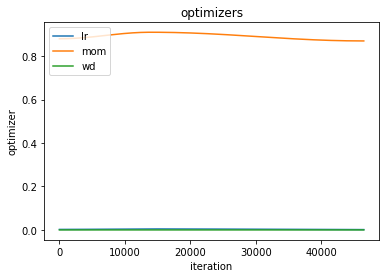

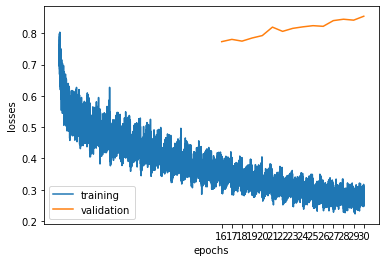

(None, None)

In [ ]:
import matplotlib.pyplot as plt

learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(skip_start=15),plt.show()

In [ ]:
%%time

stocks = test_ds.stocks[:] #"AAPL"
price_targets, prediction_columns = predict_stocks(test_ds, mm, stocks, tensor_input_view )
price_targets.head()

In [ ]:
#statistics on the columns and their predicted values
columns = test_ds.column_names.copy()
columns.extend(prediction_columns)
print(columns)
price_targets.loc[:,columns].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])        


In [ ]:
#plot signal vs prediction
#AAPL
stock             = stocks[0]
df                = price_targets.loc[stock].iloc[128:256] # extract a section
training_column   = training_column_names[0]
prediction_column = prediction_columns[0]

reference_values  = df[training_column].to_numpy()
prediction_values = df[prediction_column].to_numpy()
dates             = np.arange(len(reference_values))
same_sign         = np.sign(reference_values) == np.sign(prediction_values)

reference_same_sign  = (reference_values[same_sign],  stock+" reference", "blue",  "line")
prediction_same_sign = (prediction_values[same_sign], stock+" prediction","green","circle")
#prediction_opposite_sign = (prediction_values[np.logical_not(same_sign)], stock+" prediction","red","circle")

plotSignalVSPrediction(dates[same_sign],[reference_same_sign,prediction_same_sign])

In [ ]:
df[training_column_names].to_numpy()[:,0].shape

In [ ]:
price_targets.iloc[:10,-5:]

In [ ]:
from math import sqrt
normalization_faktor=2.7e-02
print(sqrt(0.000250), 0.01**2) #0.000295
print(sqrt(0.758663)*normalization_faktor, 0.01**2)


In [ ]:
#mm.model[0][0].weight
#mm.model[0][0].bias

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()